<a href="https://colab.research.google.com/github/SriramR02/Traffic_Flow_CTM_Kalman/blob/main/Traffic_flow_CTM_Kalman_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

# Parameters
num_cells = 10
time_minutes = np.arange(0, 120, 1)  # 8:00 AM to 10:00 AM
time_strings = [f"08:{str(m).zfill(2)}" if m<60 else f"09:{str(m-60).zfill(2)}" for m in time_minutes]

# Base density
rho_base = 10
rho_max = 50

# Initialize true density array
rho_true = np.zeros((len(time_minutes), num_cells))

# Generate synthetic true density for each cell
for t, minute in enumerate(time_minutes):
    for c in range(num_cells):
        # Base random variation
        rho_true[t, c] = rho_base + np.random.randint(-2, 3)  # ±2 vehicles

        # Add peak traffic surge between 8:30–9:15 (minutes 30–75)
        if 30 <= t <= 75:
            surge = int(15 * np.sin((t-30)/45 * np.pi))  # sinusoidal surge
            rho_true[t, c] += surge

        # Ensure density limits
        rho_true[t, c] = min(max(rho_true[t, c], 0), rho_max)

# Create CSV
data = {'Time': time_strings}
for i in range(num_cells):
    data[f'Cell_{i+1}_True'] = rho_true[:, i]

df = pd.DataFrame(data)
df.to_csv('traffic_true_density.csv', index=False)

# Preview
print(df.head(10))


    Time  Cell_1_True  Cell_2_True  Cell_3_True  Cell_4_True  Cell_5_True  \
0  08:00          8.0          9.0         11.0         10.0         10.0   
1  08:01         11.0         11.0          8.0         11.0         12.0   
2  08:02         11.0         10.0          9.0         11.0         11.0   
3  08:03         12.0         12.0         10.0         11.0         10.0   
4  08:04         10.0         11.0         10.0         12.0          9.0   
5  08:05          8.0         10.0         11.0          8.0          8.0   
6  08:06          9.0          8.0          9.0         11.0         10.0   
7  08:07         11.0         11.0         12.0         11.0         12.0   
8  08:08          9.0         12.0         11.0         12.0          8.0   
9  08:09          8.0         10.0         11.0         10.0          9.0   

   Cell_6_True  Cell_7_True  Cell_8_True  Cell_9_True  Cell_10_True  
0          8.0         12.0         11.0          9.0          10.0  
1         11

In [2]:
import numpy as np
import pandas as pd

# Load the synthetic true density CSV
df_true = pd.read_csv('traffic_true_density.csv')

num_cells = 10
num_steps = len(df_true)

# Kalman Filter parameters
F = np.eye(num_cells)  # state transition
H = np.eye(num_cells)  # measurement
Q = np.eye(num_cells) * 1  # process noise
R = np.eye(num_cells) * 4  # measurement noise

# Initial estimates
x_hat = df_true.iloc[0, 1:].values.copy()  # initial estimate = first true density
P = np.eye(num_cells)

# Store estimated densities
rho_est = np.zeros((num_steps, num_cells))
rho_est[0, :] = x_hat

# Apply Kalman Filter for each time step
for t in range(1, num_steps):
    # Prediction
    x_pred = F @ x_hat
    P_pred = F @ P @ F.T + Q

    # Measurement: true density + small noise
    z = df_true.iloc[t, 1:].values + np.random.normal(0, 1, num_cells)

    # Kalman Gain
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)

    # Update estimate
    x_hat = x_pred + K @ (z - H @ x_pred)

    # Update error covariance
    P = (np.eye(num_cells) - K @ H) @ P_pred

    # Store
    rho_est[t, :] = x_hat

# Save CSV with both true and estimated values
data = {'Time': df_true['Time']}
for i in range(num_cells):
    data[f'Cell_{i+1}_True'] = df_true[f'Cell_{i+1}_True']
    data[f'Cell_{i+1}_Est'] = rho_est[:, i]

df_est = pd.DataFrame(data)
df_est.to_csv('traffic_density_true_estimated.csv', index=False)

print(df_est.head(10))


    Time  Cell_1_True  Cell_1_Est  Cell_2_True  Cell_2_Est  Cell_3_True  \
0  08:00          8.0    8.000000          9.0    9.000000         11.0   
1  08:01         11.0    9.536399         11.0    9.809430          8.0   
2  08:02         11.0    9.616816         10.0    9.371594          9.0   
3  08:03         12.0   10.332875         12.0    9.878715         10.0   
4  08:04         10.0   10.346806         11.0    9.993409         10.0   
5  08:05          8.0    9.572053         10.0    9.762022         11.0   
6  08:06          9.0    9.455211          8.0    8.619074          9.0   
7  08:07         11.0   10.424379         11.0    9.945087         12.0   
8  08:08          9.0   10.813688         12.0   10.993334         11.0   
9  08:09          8.0    9.557635         10.0   10.171937         11.0   

   Cell_3_Est  Cell_4_True  Cell_4_Est  Cell_5_True  ...  Cell_6_True  \
0   11.000000         10.0   10.000000         10.0  ...          8.0   
1    9.910601         11.0  

In [3]:
import numpy as np
import pandas as pd

# -----------------------------
# Parameters
# -----------------------------
num_cells = 10
time_minutes = np.arange(0, 120, 1)  # 8:00 AM to 10:00 AM
time_strings = [f"08:{str(m).zfill(2)}" if m<60 else f"09:{str(m-60).zfill(2)}" for m in time_minutes]

rho_max = 50
rho_base = 10  # base density

# -----------------------------
# Generate synthetic true density
# -----------------------------
rho_true = np.zeros((len(time_minutes), num_cells))

for t, minute in enumerate(time_minutes):
    for c in range(num_cells):
        # base random variation ±2 vehicles
        rho_true[t, c] = rho_base + np.random.randint(-2, 3)
        # mid-morning peak: 8:30–9:15 (minute 30–75)
        if 30 <= t <= 75:
            surge = int(15 * np.sin((t-30)/45 * np.pi))  # sinusoidal surge
            rho_true[t, c] += surge
        # limit density between 0 and rho_max
        rho_true[t, c] = min(max(rho_true[t, c], 0), rho_max)

# -----------------------------
# Kalman Filter Initialization
# -----------------------------
F = np.eye(num_cells)  # state transition
H = np.eye(num_cells)  # measurement
Q = np.eye(num_cells) * 1  # process noise
R = np.eye(num_cells) * 4  # measurement noise

x_hat = rho_true[0, :].copy()  # initial estimate
P = np.eye(num_cells)

rho_est = np.zeros_like(rho_true)
rho_est[0, :] = x_hat

# -----------------------------
# Apply Kalman Filter
# -----------------------------
for t in range(1, len(time_minutes)):
    # Prediction
    x_pred = F @ x_hat
    P_pred = F @ P @ F.T + Q

    # Measurement: true density + small random noise
    z = rho_true[t, :] + np.random.normal(0, 1, num_cells)

    # Kalman Gain
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)

    # Update estimate
    x_hat = x_pred + K @ (z - H @ x_pred)

    # Update error covariance
    P = (np.eye(num_cells) - K @ H) @ P_pred

    # Store estimate
    rho_est[t, :] = x_hat

# -----------------------------
# Save CSV
# -----------------------------
data = {'Time': time_strings}
for i in range(num_cells):
    data[f'Cell_{i+1}_True'] = rho_true[:, i]
    data[f'Cell_{i+1}_Est'] = rho_est[:, i]

df_est = pd.DataFrame(data)
df_est.to_csv('traffic_density_true_estimated.csv', index=False)

print("CSV file 'traffic_density_true_estimated.csv' created successfully!")
print(df_est.head(10))


CSV file 'traffic_density_true_estimated.csv' created successfully!
    Time  Cell_1_True  Cell_1_Est  Cell_2_True  Cell_2_Est  Cell_3_True  \
0  08:00         10.0   10.000000         12.0   12.000000          9.0   
1  08:01         12.0   11.103656          8.0   10.408752          9.0   
2  08:02          8.0    9.648634          9.0    9.829392         12.0   
3  08:03          9.0    9.620775          8.0    8.844208          8.0   
4  08:04         10.0   10.009768         12.0   10.166442         12.0   
5  08:05         12.0   10.169045          9.0    9.889666          8.0   
6  08:06          9.0    9.469326         11.0    9.952585         11.0   
7  08:07         10.0    9.682920         11.0   10.917175         10.0   
8  08:08          9.0    9.160496         11.0   10.694255         10.0   
9  08:09         11.0    9.984389         12.0   11.019356          8.0   

   Cell_3_Est  Cell_4_True  Cell_4_Est  Cell_5_True  ...  Cell_6_True  \
0    9.000000          8.0    8.0

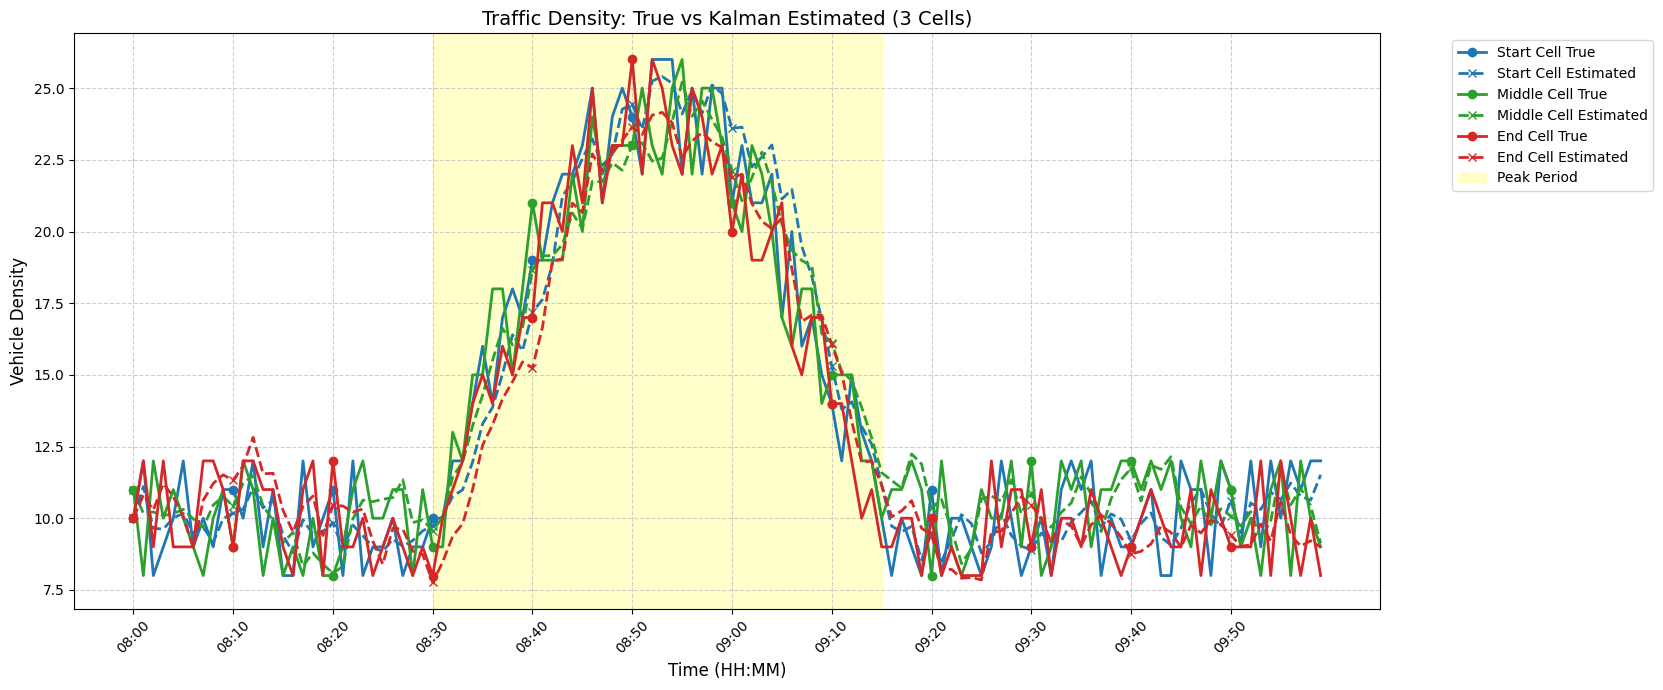

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv('traffic_density_true_estimated.csv')

# Choose 3 cells: start, middle, end
cells = [0, 4, 9]  # indices for Cell 1, Cell 5, Cell 10
labels = ['Start Cell', 'Middle Cell', 'End Cell']
colors = ['#1f77b4', '#2ca02c', '#d62728']

plt.figure(figsize=(14,7))

for idx, cell in enumerate(cells):
    # True density
    plt.plot(df['Time'], df[f'Cell_{cell+1}_True'], color=colors[idx], linestyle='-', linewidth=2,
             marker='o', markevery=10, label=f'{labels[idx]} True')
    # Estimated density
    plt.plot(df['Time'], df[f'Cell_{cell+1}_Est'], color=colors[idx], linestyle='--', linewidth=2,
             marker='x', markevery=10, label=f'{labels[idx]} Estimated')

# Highlight peak traffic period
plt.axvspan('08:30', '09:15', color='yellow', alpha=0.2, label='Peak Period')

# Reduce x-axis ticks to avoid overlap (show every 10th time point)
plt.xticks(df.index[::10], df['Time'][::10], rotation=45)

plt.xlabel('Time (HH:MM)', fontsize=12)
plt.ylabel('Vehicle Density', fontsize=12)
plt.title('Traffic Density: True vs Kalman Estimated (3 Cells)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [5]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load CSV
df = pd.read_csv('traffic_density_true_estimated.csv')

num_cells = 10
metrics = []

# Compute metrics for each cell
for i in range(num_cells):
    y_true = df[f'Cell_{i+1}_True'].values
    y_est = df[f'Cell_{i+1}_Est'].values

    mse = mean_squared_error(y_true, y_est)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_est)
    r2 = r2_score(y_true, y_est)

    metrics.append({
        'Cell': f'Cell {i+1}',
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Overall metrics (all cells combined)
y_true_all = df[[f'Cell_{i+1}_True' for i in range(num_cells)]].values.flatten()
y_est_all = df[[f'Cell_{i+1}_Est' for i in range(num_cells)]].values.flatten()

overall_metrics = {
    'MSE': mean_squared_error(y_true_all, y_est_all),
    'RMSE': np.sqrt(mean_squared_error(y_true_all, y_est_all)),
    'MAE': mean_absolute_error(y_true_all, y_est_all),
    'R2': r2_score(y_true_all, y_est_all)
}

print("Metrics per cell:")
print(df_metrics)
print("\nOverall metrics for all cells combined:")
print(overall_metrics)


Metrics per cell:
      Cell       MSE      RMSE       MAE        R2
0   Cell 1  1.642853  1.281738  1.034251  0.945061
1   Cell 2  1.827933  1.352011  1.103334  0.937813
2   Cell 3  1.518578  1.232306  0.948433  0.942460
3   Cell 4  1.696586  1.302531  0.988579  0.942426
4   Cell 5  1.397480  1.182151  0.937205  0.947163
5   Cell 6  1.453772  1.205725  0.977820  0.950266
6   Cell 7  1.277204  1.130134  0.897592  0.947259
7   Cell 8  1.585172  1.259036  1.030769  0.943543
8   Cell 9  1.558080  1.248231  0.933796  0.948093
9  Cell 10  1.674231  1.293921  1.032116  0.939938

Overall metrics for all cells combined:
{'MSE': 1.5631888352034293, 'RMSE': np.float64(1.2502755037204518), 'MAE': 0.9883894182194403, 'R2': 0.9444232336137158}
